# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [2]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [3]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [5]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


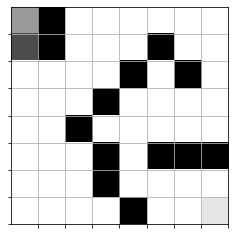

In [6]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [7]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [8]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [9]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [10]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)
    
    #Saving model
    save_path = opt.get('save_path', 'pirate_model.h5')
    save_every = opt.get('save_every', 100)
    early_stop_winrate = opt.get('early_stop_winrate', 1.0)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    for epoch in range(n_epoch):
        loss = 0.0       # Track total loss for this epoch
        n_episodes = 0   # Count how many steps the pirate takes
        win = 0          # Track if the pirate reaches the treasure

        # Pick a random free cell to start
        agent_cell = random.choice(qmaze.free_cells)

        # Reset the maze with the pirate at that starting cell
        qmaze.reset(agent_cell)

        # Get the current view of the environment
        envstate = qmaze.observe()

        # Keep going until the game ends
        while True:
            # Save the current state
            prev_envstate = envstate

            # Decide whether to explore or use the model to pick the best move
            if np.random.rand() < epsilon:
                action = random.choice(qmaze.valid_actions())  # Exploration: choose a random valid action (e.g., move left/right/up/down)
            else:
                # Exploitation: choose the best action based on model’s prediction (Q-values)
                q_values = model.predict(prev_envstate)
                action = np.argmax(q_values[0])# Pick the action with the highest Q-value

            # Take the action and get the result
            envstate, reward, game_status = qmaze.act(action) # Returns the new state, reward, and game status

            # Check if the game is over
            if game_status == 'win':  # Mark this episode as a win
                win = 1
                game_over = True
            elif game_status == 'lose':  # Pirate failed to reach the treasure
                game_over = True
            else:
                game_over = False  # Game is still ongoing

            # Save what just happened to memory
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)  # Adds this step to the experience buffer

            # Get training data from memory and update the model
            inputs, targets = experience.get_data(data_size=data_size) # Get training batch
            loss += model.train_on_batch(inputs, targets) # Perform training step and accumulate loss

            n_episodes += 1 # Count this step

            # Stop if the game is over
            if game_over:
                break

        # Add this game's result to the history
        win_history.append(win)  # Append result (1 for win, 0 for lose) to win history

        if len(win_history) > hsize:  # Keep only the most recent hsize episodes for win rate calculation
            win_history = win_history[-hsize:]
        win_rate = float(sum(win_history)) / len(win_history)#Calculate win rate over recent episodes

    
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.


    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
            
        #Periodically save the model
        if save_every and (epoch + 1) % save_every == 0:       
            model.save(save_path)
            print(f" Model saved at epoch {epoch + 1} → {save_path}")
        
    #Final save at the end
    model.save(save_path)
    print(" Final model saved to", save_path)

    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

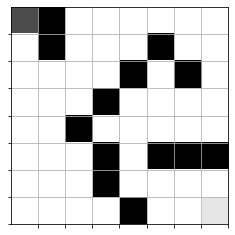

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, n_epoch=300, max_memory=8*maze.size, data_size=32)

Epoch: 000/14999 | Loss: 0.6906 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 13.0 seconds
Epoch: 001/14999 | Loss: 1.7002 | Episodes: 147 | Win count: 0 | Win rate: 0.000 | time: 26.9 seconds
Epoch: 002/14999 | Loss: 1.7106 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 39.2 seconds
Epoch: 003/14999 | Loss: 1.4636 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 52.5 seconds
Epoch: 004/14999 | Loss: 0.2472 | Episodes: 14 | Win count: 1 | Win rate: 0.200 | time: 53.7 seconds
Epoch: 005/14999 | Loss: 2.4132 | Episodes: 141 | Win count: 1 | Win rate: 0.167 | time: 64.7 seconds
Epoch: 006/14999 | Loss: 2.2630 | Episodes: 106 | Win count: 2 | Win rate: 0.286 | time: 73.8 seconds
Epoch: 007/14999 | Loss: 3.1601 | Episodes: 141 | Win count: 2 | Win rate: 0.250 | time: 86.7 seconds
Epoch: 008/14999 | Loss: 0.7575 | Episodes: 24 | Win count: 3 | Win rate: 0.333 | time: 88.6 seconds
Epoch: 009/14999 | Loss: 3.6167 | Episodes: 144 | Win count: 3 | Win rate: 0.300 | t

KeyboardInterrupt: 

This was attempt one, noticed epocs passed in defaulted to 15k which might be responsible for the really long run times, we were at 56min when I interupted.  I am now adjusting the epochs passed in to the matching name n_epochs so this runs at 300 epochs instead of 15000.  We will see what happens. 

In [13]:
model = build_model(maze)
qtrain(model, maze, n_epoch=300, max_memory=8*maze.size, data_size=32)

Epoch: 000/299 | Loss: 0.5786 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 12.4 seconds
Epoch: 001/299 | Loss: 1.8144 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 25.1 seconds
Epoch: 002/299 | Loss: 1.7816 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 38.4 seconds
Epoch: 003/299 | Loss: 1.7855 | Episodes: 150 | Win count: 0 | Win rate: 0.000 | time: 50.4 seconds
Epoch: 004/299 | Loss: 1.9517 | Episodes: 146 | Win count: 0 | Win rate: 0.000 | time: 63.6 seconds
Epoch: 005/299 | Loss: 1.6503 | Episodes: 137 | Win count: 0 | Win rate: 0.000 | time: 78.3 seconds
Epoch: 006/299 | Loss: 0.2671 | Episodes: 9 | Win count: 1 | Win rate: 0.143 | time: 79.1 seconds
Epoch: 007/299 | Loss: 0.0088 | Episodes: 3 | Win count: 2 | Win rate: 0.250 | time: 79.3 seconds
Epoch: 008/299 | Loss: 2.2125 | Episodes: 96 | Win count: 3 | Win rate: 0.333 | time: 87.2 seconds
Epoch: 009/299 | Loss: 3.4415 | Episodes: 140 | Win count: 3 | Win rate: 0.300 | time: 98.3 seconds
Epoch

3602.143137

Did not hit 100 percent with fiewer epochs, I will continue to call the function but with 500 epochs, this will put us at 800 for this model.  I will not start from scrach, but will build off of this last run.  

In [14]:
qtrain(model, maze, n_epoch=500, max_memory=8*maze.size, data_size=32)

Epoch: 000/499 | Loss: 0.4924 | Episodes: 148 | Win count: 0 | Win rate: 0.000 | time: 15.7 seconds
Epoch: 001/499 | Loss: 1.1053 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 32.8 seconds
Epoch: 002/499 | Loss: 0.0017 | Episodes: 1 | Win count: 1 | Win rate: 0.333 | time: 32.9 seconds
Epoch: 003/499 | Loss: 2.2638 | Episodes: 144 | Win count: 1 | Win rate: 0.250 | time: 51.6 seconds
Epoch: 004/499 | Loss: 1.9302 | Episodes: 134 | Win count: 1 | Win rate: 0.200 | time: 68.3 seconds
Epoch: 005/499 | Loss: 2.8743 | Episodes: 146 | Win count: 1 | Win rate: 0.167 | time: 86.2 seconds
Epoch: 006/499 | Loss: 2.4392 | Episodes: 109 | Win count: 2 | Win rate: 0.286 | time: 99.2 seconds
Epoch: 007/499 | Loss: 0.0142 | Episodes: 4 | Win count: 3 | Win rate: 0.375 | time: 99.7 seconds
Epoch: 008/499 | Loss: 7.1794 | Episodes: 80 | Win count: 4 | Win rate: 0.444 | time: 110.2 seconds
Epoch: 009/499 | Loss: 0.0896 | Episodes: 10 | Win count: 5 | Win rate: 0.500 | time: 111.8 seconds
Epoc

5628.923854

Added 500 epochs off of the previously trained model.  I noticed with more epochs it was able to get a higher overall win rate within the 500 epochs. I will now set the same one for 700 epochs to see if we can reach 100.  So in total the model has run for 800 epochs total with the 300 before, and now the 500.

In [14]:
model = build_model(maze)
qtrain(model, maze, n_epoch=1000, max_memory=8*maze.size, data_size=32)

Epoch: 000/999 | Loss: 0.5452 | Episodes: 145 | Win count: 0 | Win rate: 0.000 | time: 17.7 seconds
Epoch: 001/999 | Loss: 1.5334 | Episodes: 122 | Win count: 1 | Win rate: 0.500 | time: 33.5 seconds
Epoch: 002/999 | Loss: 1.9683 | Episodes: 136 | Win count: 1 | Win rate: 0.333 | time: 51.3 seconds
Epoch: 003/999 | Loss: 2.5259 | Episodes: 141 | Win count: 1 | Win rate: 0.250 | time: 67.0 seconds
Epoch: 004/999 | Loss: 2.3404 | Episodes: 143 | Win count: 1 | Win rate: 0.200 | time: 81.2 seconds
Epoch: 005/999 | Loss: 2.7363 | Episodes: 139 | Win count: 1 | Win rate: 0.167 | time: 94.2 seconds
Epoch: 006/999 | Loss: 0.1555 | Episodes: 1 | Win count: 2 | Win rate: 0.286 | time: 94.3 seconds
Epoch: 007/999 | Loss: 3.3772 | Episodes: 146 | Win count: 2 | Win rate: 0.250 | time: 109.2 seconds
Epoch: 008/999 | Loss: 0.8282 | Episodes: 49 | Win count: 3 | Win rate: 0.333 | time: 113.8 seconds
Epoch: 009/999 | Loss: 0.6665 | Episodes: 21 | Win count: 4 | Win rate: 0.400 | time: 115.9 seconds
E

11221.719828

Kernal was interupted and the previous model was removed from memory and not saved.  So I will need to restart this one from scratch.  This time I am starting with 1000 epochs.  The last was trained up to 800, and had a pretty high rate of 68%. 

Started over with 1000 epochs reached a high of almost 70 percent.  Will continue adding epochs unitil model is trained and reaches 100% win rate.

In [15]:
qtrain(model, maze, n_epoch=500, max_memory=8*maze.size, data_size=32)

Epoch: 000/499 | Loss: 0.3958 | Episodes: 144 | Win count: 0 | Win rate: 0.000 | time: 9.3 seconds
Epoch: 001/499 | Loss: 0.9100 | Episodes: 60 | Win count: 1 | Win rate: 0.500 | time: 13.9 seconds
Epoch: 002/499 | Loss: 1.0159 | Episodes: 52 | Win count: 2 | Win rate: 0.667 | time: 17.9 seconds
Epoch: 003/499 | Loss: 0.0831 | Episodes: 4 | Win count: 3 | Win rate: 0.750 | time: 18.3 seconds
Epoch: 004/499 | Loss: 0.2315 | Episodes: 26 | Win count: 4 | Win rate: 0.800 | time: 20.5 seconds
Epoch: 005/499 | Loss: 1.7579 | Episodes: 136 | Win count: 4 | Win rate: 0.667 | time: 30.9 seconds
Epoch: 006/499 | Loss: 1.7328 | Episodes: 79 | Win count: 5 | Win rate: 0.714 | time: 38.1 seconds
Epoch: 007/499 | Loss: 0.2759 | Episodes: 18 | Win count: 6 | Win rate: 0.750 | time: 39.6 seconds
Epoch: 008/499 | Loss: 0.1181 | Episodes: 9 | Win count: 7 | Win rate: 0.778 | time: 40.4 seconds
Epoch: 009/499 | Loss: 0.2226 | Episodes: 14 | Win count: 8 | Win rate: 0.800 | time: 41.7 seconds
Epoch: 010/

4537.491992

In [1]:
qtrain(model, maze, n_epoch=500, max_memory=8*maze.size, data_size=32)

NameError: name 'qtrain' is not defined

The model hit a higher score, and I got to 80 percent, however the connection got interupted in Apporto and I lost this model

I added the ability to save the model within the qtrain function so that the model saves every certain number of epochs set, so if Apporto crashes, I should be able to pick up where the model left off. I will build the model from scratch again, and run for a shorter number of epochs. We will start with 500.

In [21]:
model = build_model(maze)
qtrain(model, maze, n_epoch=500, save_path='pirate_model.h5', save_every=100)


Epoch: 000/499 | Loss: 0.5226 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 16.3 seconds
Epoch: 001/499 | Loss: 2.1393 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 34.2 seconds
Epoch: 002/499 | Loss: 2.0108 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 52.1 seconds
Epoch: 003/499 | Loss: 2.3146 | Episodes: 137 | Win count: 0 | Win rate: 0.000 | time: 68.8 seconds
Epoch: 004/499 | Loss: 2.4341 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 85.5 seconds
Epoch: 005/499 | Loss: 2.3137 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 102.6 seconds
Epoch: 006/499 | Loss: 2.4171 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 120.0 seconds
Epoch: 007/499 | Loss: 2.6330 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 137.1 seconds
Epoch: 008/499 | Loss: 2.0960 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 154.0 seconds
Epoch: 009/499 | Loss: 2.1380 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 173.0 sec

8630.101367

Trained this model that saves every 100 epoch.  I will run another but for 1000 epochs.

In [22]:
qtrain(model, maze, n_epoch=1000, save_path='pirate_model.h5', save_every=100)

Epoch: 000/999 | Loss: 0.2838 | Episodes: 4 | Win count: 1 | Win rate: 1.000 | time: 0.0 seconds
Epoch: 001/999 | Loss: 1.3476 | Episodes: 135 | Win count: 1 | Win rate: 0.500 | time: 17.5 seconds
Epoch: 002/999 | Loss: 0.3329 | Episodes: 9 | Win count: 2 | Win rate: 0.667 | time: 19.0 seconds
Epoch: 003/999 | Loss: 2.1176 | Episodes: 151 | Win count: 2 | Win rate: 0.500 | time: 41.7 seconds
Epoch: 004/999 | Loss: 0.1062 | Episodes: 10 | Win count: 3 | Win rate: 0.600 | time: 42.9 seconds
Epoch: 005/999 | Loss: 108.1153 | Episodes: 143 | Win count: 3 | Win rate: 0.500 | time: 60.6 seconds
Epoch: 006/999 | Loss: 2.4900 | Episodes: 140 | Win count: 3 | Win rate: 0.429 | time: 78.8 seconds
Epoch: 007/999 | Loss: 0.0568 | Episodes: 2 | Win count: 4 | Win rate: 0.500 | time: 79.1 seconds
Epoch: 008/999 | Loss: 0.4016 | Episodes: 26 | Win count: 5 | Win rate: 0.556 | time: 82.4 seconds
Epoch: 009/999 | Loss: 2.5922 | Episodes: 137 | Win count: 5 | Win rate: 0.500 | time: 98.5 seconds
Epoch: 

3100.124168

Reached the 100% win rate with 300 extra epochs from the last run of 500.  Was able to achieve this in around 800 epochs. 

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

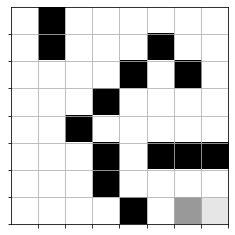

In [11]:
model = load_model('pirate_model.h5')
qmaze = TreasureMaze(maze)

completion_check(model, qmaze)
show(qmaze)

Got another name error, and needed to load the saved model from yesterday, and then try to run the completion_chek(model,qmaze).

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

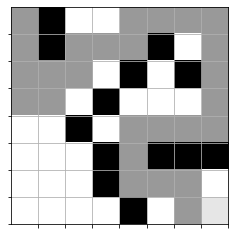

In [12]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.